## Testing SVD cutoff shaking

In [1]:
import numpy as np
import torch

from models import MPS, ComplexTensor
from utils import build_ghz_plus
from qtools import pauli_exp
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from qutip_utils import get_ghz_state as get_qutip_ghz
from utils import MeasurementDataset,train_from_dataset

import matplotlib.pyplot as plt
import datetime
from utils import make_linear_schedule, make_exp_schedule

Loaded libmkl_rt.so for dgesvd


Pick system size, dimensionality of local hilbert space, and initial bond dim

In [2]:
L=4
local_dim=2
bond_dim=2

In [3]:
# dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dev = torch.device("cpu")

Initialize the MPS model

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [5]:
psi.to(device=dev)

The ground truth state (a ghz state with no phase)

In [6]:
ghz_plus = build_ghz_plus(L)
ghz_plus.to(device=dev)
ghz_qutip = get_qutip_ghz(L,phase=0)

Samples_tr: lists indices of the observed basis states at each measurement. 0 = spin up, 1 = spin down

settings: array of corresponding angles

In [7]:
# fname_settings = "test_datasets/settings_ghz_plus_random_basis_L=%d.npy"%L
# fname_samples = "test_datasets/samples_ghz_plus_random_basis_L=%d.npy"%L
fname_settings = "datasets/mps_sampled/ghz_plus_L=%d_angles.npy"%L
fname_samples = "datasets/mps_sampled/ghz_plus_L=%d_outcomes.npy"%L
Nsamp=20000
samples = np.load(fname_samples)[:Nsamp]
samples_tr = torch.tensor((1-samples)/2).to(dtype=torch.long,device=dev)
settings = np.load(fname_settings)[:Nsamp]

In [8]:
theta = torch.tensor(settings[...,0],dtype=torch.float32,device=dev)
phi = torch.tensor(settings[...,1],dtype=torch.float32,device=dev)

Holds the unitaries corresponding to each angle

In [9]:
U = pauli_exp(theta, phi)


A dataset which yields outcomes and corresponding rotations

In [10]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)


In [11]:
batch_size = 1028
epochs=50

Max number of singular values to keep, and cutoff below which to truncate singular values

In [12]:
max_sv = 10
cutoff=1e-4

In [13]:
lr = 1e-3

In [14]:
s2_penalty = make_exp_schedule(.5, epochs // 4)

In [15]:
max_sv_to_keep = lambda ep: max_sv

In [16]:
model, logdict = train_from_dataset(ds, lr, batch_size, epochs, 
                                   s2_penalty=s2_penalty, cutoff=cutoff, 
                                   max_sv_to_keep=max_sv_to_keep, ground_truth_mps = ghz_plus, 
                                    ground_truth_qutip=ghz_qutip,
                                   use_cache=True, record_eigs=False,record_s2=True,verbose=True,
                                   early_stopping=True,compute_overlaps=True)

Training on system size 4 with 20000 samples
Finished epoch 0 in 0.768 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 1 in 1.453 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]


/home/brian/Code/mps-gm/utils.py:573: UserWarning: overlap estimate failed to converge within tolerance 1.00e-02
  warnings.warn("overlap estimate failed to converge within tolerance {0:.2e}".format(eps))


Finished epoch 2 in 1.627 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 3 in 1.597 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 4 in 1.663 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 5 in 1.586 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 6 in 1.587 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 7 in 1.594 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 8 in 1.590 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 9 in 1.296 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 10 in 1.588 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 11 in 0.821 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 12 in 1.620 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 13 in 1.467 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 14 in 1.625 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2

In [17]:
fidelity_mps = logdict['fidelity_mps']
fidelity_qutip = logdict['fidelity_qutip']
loss = logdict['loss']
max_bond_dim = logdict['max_bond_dim']
eigs = logdict['eigenvalues']
s2 = logdict['s2']
val_loss = logdict['val_loss']
overlap = logdict['overlap']

Text(0.5,1,'batch NLL loss')

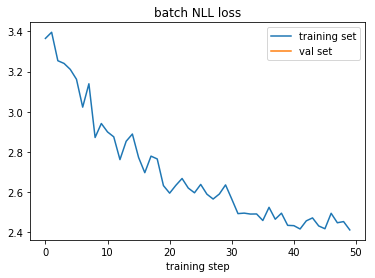

In [18]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(loss, label='training set')
plt.plot(val_loss, label='val set')
plt.legend()
plt.xlabel("training step")
plt.title("batch NLL loss")


Text(0.5,1,'Overlap during training')

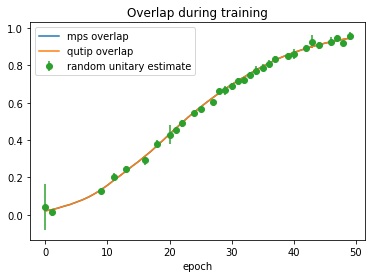

In [21]:
fig, ax = plt.subplots()
plt.plot(range(epochs), fidelity_mps**2, label='mps overlap')
plt.plot(range(epochs), fidelity_qutip**2, label='qutip overlap')
c = overlap['converged']
plt.errorbar(np.arange(epochs)[c], overlap['mean'][c], yerr=overlap['err'][c], marker='o', linestyle='none', 
            label="random unitary estimate")
plt.legend()
plt.xlabel('epoch')
plt.title("Overlap during training")